In [1]:
import numpy as np
import torch
from torch import nn
from torch import functional as F
import math

In [2]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from livelossplot import PlotLosses

In [4]:
sigma_noise = 0.1
(x_data, y_data) = torch.load('foong_data.pt')

In [5]:
sigmoid = torch.nn.Sigmoid()

In [6]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [7]:
def rho_to_sigma(rho):
    sigma = torch.log(1 + torch.exp(rho))
    return sigma

In [8]:
def sigma_to_rho(sigma):
    rho = torch.log(torch.exp(sigma) - 1)
    return rho

In [9]:
class ProbabilisticLinear(nn.Module):
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True)#, q_weight_mu = None, q_weight_rho = None, q_bias_mu = None, q_bias_rho = None):
        super(ProbabilisticLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        self.q_weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.q_weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        self.q_bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.q_bias_rho = nn.Parameter(torch.Tensor(out_features))
        
        self.weight_epsilon = torch.Tensor(out_features, in_features)
        self.bias_epsilon = torch.Tensor(out_features, in_features)
        
        self.weight_sample = torch.Tensor(out_features, in_features)
        self.bias_sample = torch.Tensor(out_features, in_features)
        
        self.reset_parameters()
        
        mu = torch.tensor(0.0)
        rho = sigma_to_rho(torch.tensor(1.0))
        
        self.prior_weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.prior_weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        self.prior_bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.prior_bias_rho = nn.Parameter(torch.Tensor(out_features))
        
        self.prior_weight_mu.requires_grad = False
        self.prior_weight_rho.requires_grad = False
        self.prior_bias_mu.requires_grad = False
        self.prior_bias_rho.requires_grad = False
        
        nn.init.constant_(self.prior_weight_mu, mu)
        nn.init.constant_(self.prior_weight_rho, rho)
        nn.init.constant_(self.prior_bias_mu, mu)
        nn.init.constant_(self.prior_bias_rho, rho)
        
    def generate_rand(self):
        self.weight_epsilon = torch.randn(size=self.q_weight_mu.size())
        self.bias_epsilon = torch.randn(size=self.q_bias_mu.size())
        return (self.weight_epsilon, self.bias_epsilon)
    
    def reparameterization(self):
        sigma_weight = rho_to_sigma(self.q_weight_rho)
        self.weight_sample = self.weight_epsilon.mul(sigma_weight).add(self.q_weight_mu)
        
        sigma_bias = rho_to_sigma(self.q_bias_rho)
        self.bias_sample = self.bias_epsilon.mul(sigma_bias).add(self.q_bias_mu)
        return (self.weight_sample, self.bias_sample)

    def q_log_pdf(self):
        sigma_weight = rho_to_sigma(self.q_weight_rho)
        nw = torch.distributions.Normal(self.q_weight_mu, sigma_weight)
        
        sigma_bias = rho_to_sigma(self.q_bias_rho)
        nb = torch.distributions.Normal(self.q_bias_mu, sigma_bias)
        
        return nw.log_prob(self.weight_sample).sum() + nb.log_prob(self.bias_sample).sum()
    
    def prior_log_pdf(self):
        sigma_weight = rho_to_sigma(self.prior_weight_rho)
        nw = torch.distributions.Normal(self.prior_weight_mu, sigma_weight)
        
        sigma_bias = rho_to_sigma(self.prior_bias_rho)
        nb = torch.distributions.Normal(self.prior_bias_mu, sigma_bias)
        
        return nw.log_prob(self.weight_sample).sum() + nb.log_prob(self.bias_sample).sum()
    
    def lock_means(self):
        self.q_weight_mu.requires_grad = False
        self.q_bias_mu.requires_grad = False
        
    def lock_rhos(self):
        self.q_weight_rho.requires_grad = False
        self.q_bias_rho.requires_grad = False
        
    def unlock_means(self):
        self.q_weight_mu.requires_grad = True
        self.q_bias_mu.requires_grad = True
        
    def unlock_rhos(self):
        self.q_weight_rho.requires_grad = True
        self.q_bias_rho.requires_grad = True
        
    def set_parameters(self, w_sample, b_sample):
        self.weight_sample = w_sample.detach()
        self.bias_sample = b_sample.detach()
    
    def reset_parameters(self):
        torch.nn.init.normal_(self.q_weight_mu, mean=0.0, std=3.0)
        torch.nn.init.constant_(self.q_weight_rho, -5.0)
        torch.nn.init.normal_(self.q_bias_mu, mean=0.0, std=3.0)
        torch.nn.init.constant_(self.q_bias_rho, -5.0)
       
    def forward(self, input):
        return torch.nn.functional.linear(input, self.weight_sample, bias=self.bias_sample)

In [23]:
a = None

In [10]:
class RegressionModel(nn.Module):
    def __init__(self, H, mu_init = None, sigma_init = None):
        super(RegressionModel, self).__init__()
        
        self.linear1 = ProbabilisticLinear(1, H)
        self.linear2 = ProbabilisticLinear(H,1)
        
        self.registered_layers = []
        self.registered_layers.append(self.linear1)
        self.registered_layers.append(self.linear2)
        
        
        self.nb_parameters = self.count_parameters()
        
    def forward(self, x):
        out = x;
        for k in range(len(self.registered_layers)-1):
            out = torch.tanh(self.registered_layers[k](out))
        out = self.registered_layers[-1](out)
        return out
    
    def resample_parameters(self):
        w_samples = []
        b_samples = []
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].generate_rand()
            self.registered_layers[k].reparameterization()
        
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def lock_means(self):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].lock_means()
        
    def lock_rhos(self):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].lock_rhos()
        
    def unlock_means(self):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].unlock_means()
        
    def unlock_rhos(self):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].unlock_rhos()
            
    def set_parameters(self, w_samples, b_samples):
        for k in range(len(self.registered_layers)):
            self.registered_layers[k].set_parameters(w_samples[k], b_samples[k])
    
    def q_log_pdf(self):
        list_LQ = []
        for k in range(len(self.registered_layers)):
            list_LQ.append(self.registered_layers[k].q_log_pdf())
        stack_LQ = torch.stack(list_LQ)
        return torch.sum(stack_LQ)
    
    def prior_log_pdf(self):
        list_LP = []
        for k in range(len(self.registered_layers)):
            list_LP.append(self.registered_layers[k].prior_log_pdf())
        stack_LP = torch.stack(list_LP)
        return torch.sum(stack_LP)
        
    def compute_elbo(self, x_data, y_data, sample_size):
        L = []
        for _ in range(sample_size):
            self.resample_parameters()

            LQ = self.q_log_pdf() 
            LP = self.prior_log_pdf() 

            y_pred = self.forward(x_data)
            LL = log_norm(y_data, y_pred.t(), torch.tensor(sigma_noise)).sum()

            L.append(LQ - LP - LL)
        L = torch.stack(L)
        L = torch.mean(L)
        return L

In [ ]:
def L2(tensor):
    return (tensor*tensor).sum().sqrt()
L2_vect = np.vectorize(L2)

In [ ]:
range(12, 12)

In [ ]:
def distance_matrix(list_of_tensors):
    m = len(list_of_tensors)
    D = torch.diag(L2_vec(list_of_tensors))
    for i in range(m):
        for j in range(i+1, m):
            

In [165]:
class BoostingModel(nn.Module):
    
    def __init__(self, H, nComponents):
        super(BoostingModel, self).__init__()
        
        self.H = H
        self.components = [RegressionModel(H)]
        self.mixture_probas = torch.tensor([1.])
        self.nComponents = nComponents
        self.current_nComponents = 1
        self.current_component = self.components[0]
        self.current_component_index = 0
        self.current_parameters = {'weight': [layer.weight_sample for layer in self.current_component.registered_layers],
                                   'bias': [layer.bias_sample for layer in self.current_component.registered_layers]}
        self.current_proba_parameter = None
        
    def mu_distances(self):
        
        d = {'linear1': torch.tensor()}
        
        
        
    def refresh_current_parameters(self):
        self.current_parameters = {'weight': [layer.weight_sample for layer in self.current_component.registered_layers],
                                   'bias': [layer.bias_sample for layer in self.current_component.registered_layers]}
    
    def forward(self, x):
        out = self.current_component(x)
        return out
    
    def resample_parameters_in_eval(self):
        self.sample_component(last = True)
        self.sample_parameters()
        self.refresh_current_parameters()
        
    def resample_parameters_in_train(self):
        self.sample_component(last = False)
        self.sample_parameters()
        self.refresh_current_parameters()
    
    def sample_component(self, last = False):
        
        if len(self.components) == 1:
            self.current_component
        
        elif not last:
            self.current_component = np.random.choice(self.components[:-1], p = self.mixture_probas.data.numpy())
        else:
            pi = sigmoid(self.current_proba_parameter.detach())
            self.current_component = np.random.choice(self.components, p = torch.cat(((1-pi)*self.mixture_probas, pi.unsqueeze(0))).numpy())

    def sample_parameters(self):
        self.current_component.resample_parameters()
        
    def mixture_log_pdf(self):
        pi = sigmoid(self.current_proba_parameter)
        probs = torch.cat((self.mixture_probas*(1-pi), pi.unsqueeze(0)))
        #print('probs', probs)
        log_q = []
        for i, component in enumerate(self.components):
            component.set_parameters(self.current_parameters['weight'], self.current_parameters['bias'])
         #   print("log_q_comp", component.q_log_pdf())
         #   print('prob', probs[i])
            log_q.append(component.q_log_pdf())
        log_q = torch.stack(log_q)
        #print('GO')
        #print('before anything', log_q)
        #signs = log_q.detach().sign()
        #log_q = log_q*signs
        #print('after signs', log_q)
        #log_q = log_q**probs
        #print('after probs', log_q)
        #log_q = log_q*signs
        #log_q = torch.logsumexp(log_q, dim = -1)
        #print('stacked log q', log_q)
        maximum = log_q.max()
        #print('maximum', maximum)
        """investigate gradient of max"""
        log_q = log_q - maximum
        log_q = torch.exp(log_q)
        log_q = log_q*probs
        log_q = torch.log(torch.sum(log_q)) + maximum
        return(log_q)
    
    def compute_mixture_elbo(self, x_data, y_data, sample_size):
        if type(self.current_proba_parameter) != type(None):
            
            pi_new = sigmoid(self.current_proba_parameter)
            
        
            """Compute expectancy w.r.t old mixture"""
            L_old_mixture = []
            for _ in range(sample_size):
                self.resample_parameters_in_train()
                LQ = self.mixture_log_pdf()
                y_pred = self.forward(x_data)
                LL = log_norm(y_data, y_pred.t(), torch.tensor(sigma_noise)).sum()
                L_old_mixture.append(LQ - LL)
            L_old_mixture = torch.stack(L_old_mixture)
            L_old_mixture = torch.mean(L_old_mixture)
            #print(L_old_mixture)

            """Compute expectancy w.r.t new component"""
            L_new_component = []
            for _ in range(sample_size):
                self.current_component = self.components[-1]
                self.sample_parameters()
                self.refresh_current_parameters()
                LQ = self.mixture_log_pdf()
                self.sample_component(last = True)
                y_pred = self.forward(x_data)
                LL = log_norm(y_data, y_pred.t(), torch.tensor(sigma_noise)).sum()
                L_new_component.append(LQ - LL)
            L_new_component = torch.stack(L_new_component)
            L_new_component = torch.mean(L_new_component)
            #print(L_new_component)
            L = (1 - pi_new)*L_old_mixture + pi_new*L_new_component
            return L
        else:
            return(self.components[0].compute_elbo(x_data, y_data, sample_size))
    
    
    def new_component(self, losses, epsilon, new_pi):
        #print('std losses',torch.std(losses))
        
        if epsilon and len(self.components)<self.nComponents:
        #if torch.std(losses) < epsilon and len(self.components)<self.nComponents:
            print("WE GOT THERE !!!!")
            for component in self.components:
                """lock fonctionne ?"""
                component.lock_means()
                component.lock_rhos()
            
            self.components.append(RegressionModel(self.H))
            if type(self.current_proba_parameter) != type(None):
                self.current_proba_parameter.detach_()
                pi = sigmoid(self.current_proba_parameter)
                self.mixture_probas = torch.cat((self.mixture_probas*(1 - pi), pi.unsqueeze(0)))
            self.current_proba_parameter = torch.tensor(float(new_pi))#, requires_grad = True)
            print('NEW COMPONENT OK')
            return 1
#torch.std(losses) < epsilon
        else:
            return 0

In [166]:
"""
- Underfit the first component
- Initialize with prefitted new components
"""

'\n- Underfit the first component\n- Initialize with prefitted new components\n'

In [171]:
model = BoostingModel(50, 2)

In [172]:
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.95,verbose=True)
optimizer.zero_grad()

KeyboardInterrupt: 

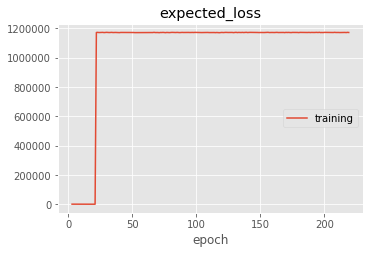

In [173]:
%matplotlib inline
num_epoch = 300
num_iterations = 100
liveloss = PlotLosses()

M = int(.005/learning_rate)+1
M=5
for j in range(num_epoch):
    new_comp_this_epoch = 0
    logs = {}
    losses = [None] * num_iterations
    
    for k in range(num_iterations):
        optimizer.zero_grad()
        if new_comp_this_epoch:
            print('before grad', model.current_proba_parameter)
        loss = model.compute_mixture_elbo(x_data, y_data, M)
        losses[k] = loss.detach()
        loss.backward()
        #if new_comp_this_epoch:
        #    print('after grad', model.current_proba_parameter)
        #print(model.components[0].linear1.weight_sample.grad)
        gradients = model.components[-1].linear1.q_weight_mu.grad.mean()
        
        optimizer.step()
        #print(model.current_proba_parameter)
    if j>1:
        new_comp = model.new_component(None, epsilon = (j%20 == 0), new_pi = 0)#np.log(1./(4*model.nComponents+3)))

        #print('STOP', stop)
        if new_comp:
            model.current_nComponents += 1
            print("J", j, "COMPONENTS", len(model.components))
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            optimizer.add_param_group({"params": model.current_proba_parameter, 'lr': .05})

        #print(model.current_proba_parameter)
    #print(model.mixture_probas)
    #print(torch.std(torch.stack(losses[k-4:k])))
    def f(x):
        if type(x) == type(None):
            return(1.)
        else:
            return(sigmoid(x))
    #f = lambda x: {type(None): 1}.get(type(x), sigmoid(x))
    logs['expected_loss'] = torch.stack(losses).mean().detach().clone().numpy()
    logs['learning rate'] = optimizer.param_groups[0]['lr']
    logs['ncomponents'] = len(model.components)
    logs['current_proba'] = f(model.current_proba_parameter)
    logs['gradients_weights'] = gradients
    #iilogs['proba_gradients'] = prob_grad
    #if type(model.current_proba_parameter) != type(None):
    #    logs['current_proba'] = model.current_proba_parameter.detach().data
    lr = optimizer.param_groups[0]['lr']
    M = int(.005/lr)+1
    M=5
    #print(M)
    liveloss.update(logs)
    liveloss.draw()
    #print('epoch', j, 'num_components', len(model.components), 'stop', stop)
    
    scheduler.step(logs['expected_loss'])
    
    

In [77]:
loss = model.forward(x_data)

In [127]:
loss = model.mixture_log_pdf()

In [152]:
loss = model.compute_mixture_elbo(x_data, y_data, M)

In [153]:
loss

tensor(1458.1899, grad_fn=<MulBackward0>)

In [154]:
loss.backward()

In [155]:
model.components[-1].linear1.q_weight_mu.grad

tensor([[-5.9397e-04],
        [ 1.0016e-03],
        [-4.4646e-04],
        [ 1.1627e-04],
        [ 1.3744e-03],
        [-2.2294e-03],
        [ 1.4354e-03],
        [ 2.0348e-03],
        [-1.1218e-03],
        [-2.4766e-03],
        [-9.9182e-05],
        [ 1.5330e-04],
        [ 6.7857e-04],
        [ 2.5956e-03],
        [ 1.0789e-03],
        [-1.7995e-03],
        [ 1.5810e-03],
        [-2.6595e-03],
        [-3.1624e-05],
        [ 1.7452e-03],
        [-4.0419e-04],
        [-2.3826e-03],
        [-2.7879e-03],
        [-8.4686e-04],
        [-1.1913e-03],
        [ 1.6628e-03],
        [-7.1147e-04],
        [-3.5753e-04],
        [-2.3557e-03],
        [ 1.4602e-03],
        [ 2.8380e-03],
        [-1.2802e-03],
        [-3.9054e-04],
        [-7.3778e-04],
        [ 9.8283e-04],
        [ 1.3812e-03],
        [ 2.6370e-03],
        [ 2.8750e-03],
        [-8.3812e-04],
        [-2.8533e-03],
        [ 1.4253e-03],
        [ 4.0553e-04],
        [ 6.9835e-04],
        [ 6

In [79]:
loss

tensor([[ 6.3178],
        [ 6.7339],
        [ 6.8020],
        [ 6.4573],
        [ 6.3460],
        [ 6.1342],
        [ 6.3708],
        [ 6.9426],
        [ 6.3006],
        [ 6.2289],
        [ 6.7864],
        [ 5.9156],
        [ 5.9571],
        [ 6.6979],
        [ 6.0999],
        [ 6.5616],
        [ 6.5451],
        [ 6.9388],
        [ 6.6847],
        [ 6.2879],
        [ 5.8126],
        [ 6.6394],
        [ 6.1699],
        [ 6.4289],
        [ 6.8629],
        [ 5.8339],
        [ 6.7764],
        [ 5.7553],
        [ 6.1235],
        [ 6.8961],
        [ 5.7552],
        [ 6.7602],
        [ 6.5350],
        [ 6.3210],
        [ 6.1398],
        [ 6.1944],
        [ 6.8754],
        [ 6.7715],
        [ 6.8968],
        [ 6.6031],
        [ 6.7859],
        [ 6.8253],
        [ 6.9049],
        [ 6.9519],
        [ 6.3608],
        [ 6.8310],
        [ 5.9391],
        [ 6.3082],
        [ 6.5931],
        [ 6.0663],
        [ 6.6965],
        [ 6.7874],
        [ 6.

In [78]:
loss.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [381]:
%matplotlib inline
num_epoch = 100
num_iterations = 100
liveloss = PlotLosses()

M = int(.005/learning_rate)+1
M=10
for j in range(num_epoch):
    logs = {}
    losses = [None] * num_iterations
    
    for k in range(num_iterations):
        optimizer.zero_grad()
        loss = model.compute_mixture_elbo(x_data, y_data, M)
        losses[k] = loss.detach()
        loss.backward()
        #print(model.components[0].linear1.weight_sample.grad)
        optimizer.step()
        print(model.current_proba_parameter)
        if k>4:
            stop = model.new_component(torch.stack(losses[k-4:k]), epsilon = 50, new_pi = .5)
            
            #print('STOP', stop)
            if not stop:
                print('new_component')
                break
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #print(model.mixture_probas)
    #print(torch.std(torch.stack(losses[k-4:k])))
    logs['expected_loss'] = torch.stack(losses).mean().detach().clone().numpy()
    logs['learning rate'] = optimizer.param_groups[0]['lr']
    lr = optimizer.param_groups[0]['lr']
    M = int(.005/lr)+1
    M=10
    #print(M)
    liveloss.update(logs)
    #liveloss.draw()
    #print('epoch', j, 'num_components', len(model.components), 'stop', stop)
    
    scheduler.step(logs['expected_loss'])

None
None
None
None
None
None
std losses tensor(225065.0938)
None
std losses tensor(81373.9531)
None
std losses tensor(57236.8359)
None
std losses tensor(80391.8516)
None
std losses tensor(60620.0703)
None
std losses tensor(24250.9844)
None
std losses tensor(34824.5703)
None
std losses tensor(55225.5625)
None
std losses tensor(59821.3945)
None
std losses tensor(48727.1094)
None
std losses tensor(31881.7969)
None
std losses tensor(13890.7715)
None
std losses tensor(7090.0781)
None
std losses tensor(13719.4160)
None
std losses tensor(16131.4512)
None
std losses tensor(13211.7627)
None
std losses tensor(7068.8350)
None
std losses tensor(3132.5833)
None
std losses tensor(8619.9785)
None
std losses tensor(13056.0273)
None
std losses tensor(14447.5996)
None
std losses tensor(11914.5498)
None
std losses tensor(7902.5571)
None
std losses tensor(3698.8779)
None
std losses tensor(1941.7659)
None
std losses tensor(3839.4480)
None
std losses tensor(4812.2295)
None
std losses tensor(4358.5103)
None

log_q_comp tensor(-29103700.)
prob tensor(0.5000, grad_fn=<SelectBackward>)
log_q_comp tensor(549.2662, grad_fn=<SumBackward0>)
prob tensor(0.5000, grad_fn=<SelectBackward>)
stacked log q tensor([-2.9104e+07,  5.4927e+02], grad_fn=<StackBackward>)
maximum tensor(549.2662, grad_fn=<MaxBackward1>)
log_q before exp tensor([-29104250.,         0.], grad_fn=<SubBackward0>)
log_q after exp tensor([0., 1.], grad_fn=<ExpBackward>)
log_q ponderated tensor([0.0000, 0.5000], grad_fn=<MulBackward0>)
log_q tensor(548.5731, grad_fn=<AddBackward0>)
probs tensor([0.5000, 0.5000], grad_fn=<CatBackward>)
log_q_comp tensor(-29095512.)
prob tensor(0.5000, grad_fn=<SelectBackward>)
log_q_comp tensor(549.9595, grad_fn=<SumBackward0>)
prob tensor(0.5000, grad_fn=<SelectBackward>)
stacked log q tensor([-2.9096e+07,  5.4996e+02], grad_fn=<StackBackward>)
maximum tensor(549.9595, grad_fn=<MaxBackward1>)
log_q before exp tensor([-29096062.,         0.], grad_fn=<SubBackward0>)
log_q after exp tensor([0., 1.], gr

log_q after exp tensor([0., 1.], grad_fn=<ExpBackward>)
log_q ponderated tensor([0.0000, 0.5000], grad_fn=<MulBackward0>)
log_q tensor(548.4786, grad_fn=<AddBackward0>)
probs tensor([0.5000, 0.5000], grad_fn=<CatBackward>)
log_q_comp tensor(-29001872.)
prob tensor(0.5000, grad_fn=<SelectBackward>)
log_q_comp tensor(535.7921, grad_fn=<SumBackward0>)
prob tensor(0.5000, grad_fn=<SelectBackward>)
stacked log q tensor([-2.9002e+07,  5.3579e+02], grad_fn=<StackBackward>)
maximum tensor(535.7921, grad_fn=<MaxBackward1>)
log_q before exp tensor([-29002408.,         0.], grad_fn=<SubBackward0>)
log_q after exp tensor([0., 1.], grad_fn=<ExpBackward>)
log_q ponderated tensor([0.0000, 0.5000], grad_fn=<MulBackward0>)
log_q tensor(535.0989, grad_fn=<AddBackward0>)
probs tensor([0.5000, 0.5000], grad_fn=<CatBackward>)
log_q_comp tensor(-29002170.)
prob tensor(0.5000, grad_fn=<SelectBackward>)
log_q_comp tensor(550.2764, grad_fn=<SumBackward0>)
prob tensor(0.5000, grad_fn=<SelectBackward>)
stacked l

log_q ponderated tensor([0.5000, 0.0000], grad_fn=<MulBackward0>)
log_q tensor(453.1341, grad_fn=<AddBackward0>)
probs tensor([0.5000, 0.5000], grad_fn=<CatBackward>)
log_q_comp tensor(446.7407)
prob tensor(0.5000, grad_fn=<SelectBackward>)
log_q_comp tensor(-32089972., grad_fn=<SumBackward0>)
prob tensor(0.5000, grad_fn=<SelectBackward>)
stacked log q tensor([ 4.4674e+02, -3.2090e+07], grad_fn=<StackBackward>)
maximum tensor(446.7407, grad_fn=<MaxBackward1>)
log_q before exp tensor([        0., -32090418.], grad_fn=<SubBackward0>)
log_q after exp tensor([1., 0.], grad_fn=<ExpBackward>)
log_q ponderated tensor([0.5000, 0.0000], grad_fn=<MulBackward0>)
log_q tensor(446.0475, grad_fn=<AddBackward0>)
probs tensor([0.5000, 0.5000], grad_fn=<CatBackward>)
log_q_comp tensor(458.4803)
prob tensor(0.5000, grad_fn=<SelectBackward>)
log_q_comp tensor(-32252048., grad_fn=<SumBackward0>)
prob tensor(0.5000, grad_fn=<SelectBackward>)
stacked log q tensor([ 4.5848e+02, -3.2252e+07], grad_fn=<StackBa

prob tensor(0.5000, grad_fn=<SelectBackward>)
log_q_comp tensor(538.0101, grad_fn=<SumBackward0>)
prob tensor(0.5000, grad_fn=<SelectBackward>)
stacked log q tensor([-2.8800e+07,  5.3801e+02], grad_fn=<StackBackward>)
maximum tensor(538.0101, grad_fn=<MaxBackward1>)
log_q before exp tensor([-28800974.,         0.], grad_fn=<SubBackward0>)
log_q after exp tensor([0., 1.], grad_fn=<ExpBackward>)
log_q ponderated tensor([0.0000, 0.5000], grad_fn=<MulBackward0>)
log_q tensor(537.3169, grad_fn=<AddBackward0>)
probs tensor([0.5000, 0.5000], grad_fn=<CatBackward>)
log_q_comp tensor(-28800926.)
prob tensor(0.5000, grad_fn=<SelectBackward>)
log_q_comp tensor(541.1519, grad_fn=<SumBackward0>)
prob tensor(0.5000, grad_fn=<SelectBackward>)
stacked log q tensor([-2.8801e+07,  5.4115e+02], grad_fn=<StackBackward>)
maximum tensor(541.1519, grad_fn=<MaxBackward1>)
log_q before exp tensor([-28801468.,         0.], grad_fn=<SubBackward0>)
log_q after exp tensor([0., 1.], grad_fn=<ExpBackward>)
log_q pon

maximum tensor(532.9903, grad_fn=<MaxBackward1>)
log_q before exp tensor([-28728668.,         0.], grad_fn=<SubBackward0>)
log_q after exp tensor([0., 1.], grad_fn=<ExpBackward>)
log_q ponderated tensor([0.0000, 0.5000], grad_fn=<MulBackward0>)
log_q tensor(532.2971, grad_fn=<AddBackward0>)
probs tensor([0.5000, 0.5000], grad_fn=<CatBackward>)
log_q_comp tensor(-28736436.)
prob tensor(0.5000, grad_fn=<SelectBackward>)
log_q_comp tensor(536.0091, grad_fn=<SumBackward0>)
prob tensor(0.5000, grad_fn=<SelectBackward>)
stacked log q tensor([-2.8736e+07,  5.3601e+02], grad_fn=<StackBackward>)
maximum tensor(536.0091, grad_fn=<MaxBackward1>)
log_q before exp tensor([-28736972.,         0.], grad_fn=<SubBackward0>)
log_q after exp tensor([0., 1.], grad_fn=<ExpBackward>)
log_q ponderated tensor([0.0000, 0.5000], grad_fn=<MulBackward0>)
log_q tensor(535.3159, grad_fn=<AddBackward0>)
tensor(-5748931., grad_fn=<MeanBackward0>)
tensor(0.5000, requires_grad=True)
std losses tensor(1664.6460)
probs t

stacked log q tensor([ 4.4918e+02, -3.2246e+07], grad_fn=<StackBackward>)
maximum tensor(449.1830, grad_fn=<MaxBackward1>)
log_q before exp tensor([        0., -32246858.], grad_fn=<SubBackward0>)
log_q after exp tensor([1., 0.], grad_fn=<ExpBackward>)
log_q ponderated tensor([0.5000, 0.0000], grad_fn=<MulBackward0>)
log_q tensor(448.4898, grad_fn=<AddBackward0>)
probs tensor([0.5000, 0.5000], grad_fn=<CatBackward>)
log_q_comp tensor(437.4698)
prob tensor(0.5000, grad_fn=<SelectBackward>)
log_q_comp tensor(-32193912., grad_fn=<SumBackward0>)
prob tensor(0.5000, grad_fn=<SelectBackward>)
stacked log q tensor([ 4.3747e+02, -3.2194e+07], grad_fn=<StackBackward>)
maximum tensor(437.4698, grad_fn=<MaxBackward1>)
log_q before exp tensor([        0., -32194350.], grad_fn=<SubBackward0>)
log_q after exp tensor([1., 0.], grad_fn=<ExpBackward>)
log_q ponderated tensor([0.5000, 0.0000], grad_fn=<MulBackward0>)
log_q tensor(436.7766, grad_fn=<AddBackward0>)
probs tensor([0.5000, 0.5000], grad_fn=<

log_q before exp tensor([-28589536.,         0.], grad_fn=<SubBackward0>)
log_q after exp tensor([0., 1.], grad_fn=<ExpBackward>)
log_q ponderated tensor([0.0000, 0.5000], grad_fn=<MulBackward0>)
log_q tensor(518.6584, grad_fn=<AddBackward0>)
probs tensor([0.5000, 0.5000], grad_fn=<CatBackward>)
log_q_comp tensor(-28598000.)
prob tensor(0.5000, grad_fn=<SelectBackward>)
log_q_comp tensor(545.3545, grad_fn=<SumBackward0>)
prob tensor(0.5000, grad_fn=<SelectBackward>)
stacked log q tensor([-2.8598e+07,  5.4535e+02], grad_fn=<StackBackward>)
maximum tensor(545.3545, grad_fn=<MaxBackward1>)
log_q before exp tensor([-28598546.,         0.], grad_fn=<SubBackward0>)
log_q after exp tensor([0., 1.], grad_fn=<ExpBackward>)
log_q ponderated tensor([0.0000, 0.5000], grad_fn=<MulBackward0>)
log_q tensor(544.6613, grad_fn=<AddBackward0>)
probs tensor([0.5000, 0.5000], grad_fn=<CatBackward>)
log_q_comp tensor(-28575828.)
prob tensor(0.5000, grad_fn=<SelectBackward>)
log_q_comp tensor(536.7795, grad_

prob tensor(0.5000, grad_fn=<SelectBackward>)
stacked log q tensor([ 4.5951e+02, -3.2249e+07], grad_fn=<StackBackward>)
maximum tensor(459.5050, grad_fn=<MaxBackward1>)
log_q before exp tensor([        0., -32249044.], grad_fn=<SubBackward0>)
log_q after exp tensor([1., 0.], grad_fn=<ExpBackward>)
log_q ponderated tensor([0.5000, 0.0000], grad_fn=<MulBackward0>)
log_q tensor(458.8119, grad_fn=<AddBackward0>)
probs tensor([0.5000, 0.5000], grad_fn=<CatBackward>)
log_q_comp tensor(453.5767)
prob tensor(0.5000, grad_fn=<SelectBackward>)
log_q_comp tensor(-32245938., grad_fn=<SumBackward0>)
prob tensor(0.5000, grad_fn=<SelectBackward>)
stacked log q tensor([ 4.5358e+02, -3.2246e+07], grad_fn=<StackBackward>)
maximum tensor(453.5767, grad_fn=<MaxBackward1>)
log_q before exp tensor([        0., -32246392.], grad_fn=<SubBackward0>)
log_q after exp tensor([1., 0.], grad_fn=<ExpBackward>)
log_q ponderated tensor([0.5000, 0.0000], grad_fn=<MulBackward0>)
log_q tensor(452.8835, grad_fn=<AddBackwa

KeyboardInterrupt: 

In [228]:
model = RegressionModel(50)

In [ ]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

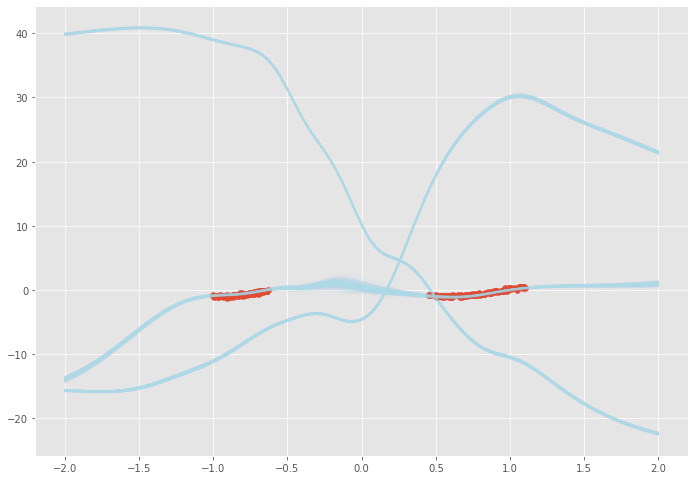

In [170]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    model.resample_parameters_in_eval()

    y_test = model.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

AttributeError: 'BoostingModel' object has no attribute 'resample_parameters'

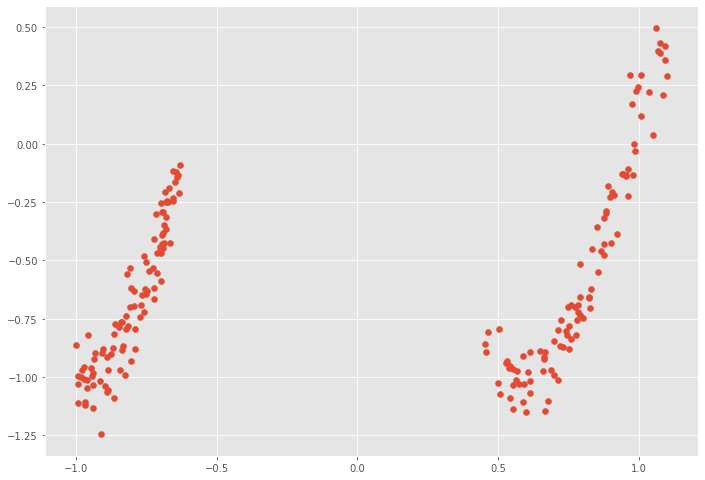

In [57]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    model.resample_parameters()

    y_test = model.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [139]:
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/cortax/Anaconda3/Library/bin/graphviz/'

In [140]:
#make_dot(model(x_data), params=dict(model.named_parameters()))

In [234]:
model = RegressionModel(50)

In [235]:
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.95,verbose=True)
optimizer.zero_grad()

In [64]:
model.mixture_probas.numel()

1

KeyboardInterrupt: 

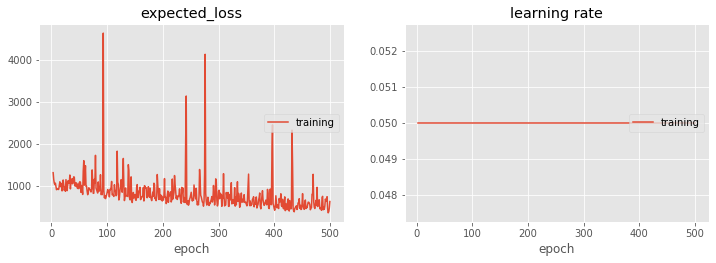

In [236]:
%matplotlib inline
num_epoch = 1000
num_iterations = 100
liveloss = PlotLosses()

M = int(.005/learning_rate)+1
for j in range(num_epoch):
    logs = {}
    losses = [None] * num_iterations
    
    for k in range(num_iterations):
        optimizer.zero_grad()
        loss = model.compute_elbo(x_data, y_data, M)
        losses[k] = loss
        loss.backward()
        #print(model.linear1.weight_sample.grad)
        optimizer.step()
    
    logs['expected_loss'] = torch.stack(losses).mean().detach().clone().numpy()
    logs['learning rate'] = optimizer.param_groups[0]['lr']
    lr = optimizer.param_groups[0]['lr']
    M = int(.005/lr)+1
    print(M)
    liveloss.update(logs)
    liveloss.draw()
    
    scheduler.step(logs['expected_loss'])
    

In [18]:
model.requires_grad_(False)

RegressionModel(
  (linear1): ProbabilisticLinear()
  (linear2): ProbabilisticLinear()
)

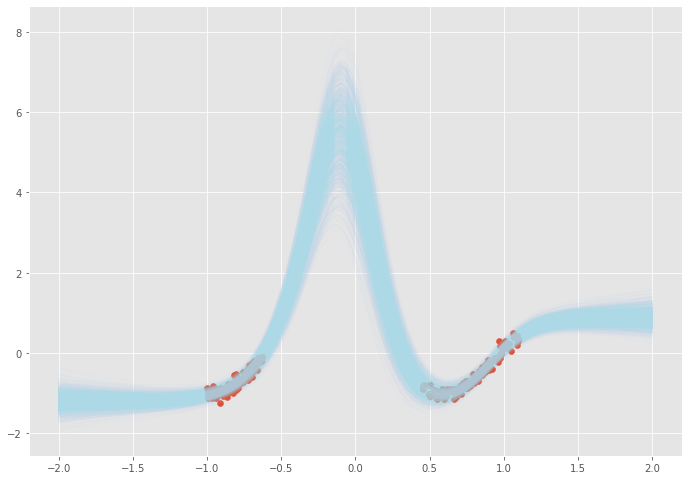

In [158]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    (L1_weight_epsilon, L1_bias_epsilon) = model.linear1.generate_rand()
    (L1_weight_sample, L1_bias_sample) = model.linear1.reparameterization()
    
    y_test = model.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')